In [2]:
import numpy as np
from numpy.random import default_rng
from time import time
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import linear_model  
import random
import math

### Some functions needed for global calculations

In [3]:
def dup_rows(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)

def dup_cols(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[:,[indx]],axis=1)
def function_exp(x):
    return np.exp(x)
function_vexp = np.vectorize(function_exp)
def function_bin(p,x):
    return (p**x)*(1-p)**(1-x)
function_vbin = np.vectorize(function_bin)
def function_binlog(p,x):
    return (x*np.log(p)+(1-x)*np.log(1-p))
function_vbinlog = np.vectorize(function_binlog)

### EM

In [4]:
#Section 2.2-The initial estimator-EM
def em_single_initial(n,K,priors,X,Y):
    '''
    EM
    Arguments:
    priors:[pi_t,gamma_t,theta_t,sigma_t]
    Y:[n X 1 list]
    X:[n X q matrix]
    
    Returns:
    new_priors:[new_pi,new_gamma,new_theta,new_sigma]
    pi_t = priors[1:K]; gamma_t = priors[K:2*K]
    theta_t = priors[2*K:2*K+q]; sigma_t = priors[-1]
    '''
    pi_t = priors[0:K]; gamma_t = priors[K:2*K]
    theta_t = priors[2*K:2*K+q]; sigma_t = priors[-1]
    #E step -w_ik
    c = Y-np.dot(X,theta_t)
    g = np.array(gamma_t)
    g_pi = np.array(pi_t)
    a1 = (np.ones((K,n))*c.T).T
    a2 = np.ones((n,K))*g
    e_pri = -(a1-a2)**2/(2*sigma_t**2)
    e_pri = function_vexp(e_pri)
    a_pi = np.ones((n,K))*g_pi
    w_t1 = (np.divide((e_pri*a_pi).T,(np.sum(e_pri*a_pi,1)).T)).T
    

    #M step 
    new_pi = np.average(w_t1, axis=0) 
    weight = np.divide(w_t1,sum(w_t1,0))
    new_gamma = np.dot(weight.T, Y-np.dot(X, theta_t))
    V = np.dot(w_t1,gamma_t)
    trt_inv = np.dot(np.linalg.inv(np.dot(X.T,X)+np.eye(q)*0.001),X.T)
    new_theta = np.dot(trt_inv,Y-V)
    sum_sigma = 0
    w_t1_gamma_t = np.dot(w_t1,gamma_t)
    sum_sigma = {np.dot(((Y-np.dot(X,theta_t))**2).T,[1]*n)-
              2*np.dot(np.multiply(Y-np.dot(X,theta_t),w_t1_gamma_t).T,[1]*n)+
                np.dot(np.dot(w_t1,np.array(gamma_t)**2),[1]*n)}
    new_sigma = (list(sum_sigma)[0]/n)**0.5
    return list(new_pi)+list(new_gamma)+list(new_theta)+[new_sigma]

In [5]:
def initial_em(n,K,prior,X,Y,tol = 1e-3,iterations=1000):
    '''
    EM
    param Y,X :Data
    param prior：Initial
    param tol：End of Iteration Threshold
    param iterations：Maximum number of iterations
    return：Locally optimal model parameters
    '''
    iteration = 0;
    while iteration < iterations:
        new_prior = em_single_initial(n,K,prior,X,Y)
        delta_change = abs(np.array(prior)-np.array(new_prior))
        if sum(delta_change**2)**0.5<tol:
            break
        else:
            prior = new_prior
            iteration +=1
    return [new_prior,iteration]

In [6]:
def em_single_for_p(n,p,K,initial,prior_p,X,Y,Z):
    '''
    EM
    Arguments:
    initial: [pi_h,gamma_h,theta_h,sigma_h]
    priors:pj [k X 1 list]
    Y:[n X 1 list]
    X:[n X q matrix]
    Z:[n X p matrix]
    j: for p
    
    Returns:
    new_priors:new_pj
    '''
    pi_h = initial[0:K]; gamma_h = initial[K:2*K]
    theta_h = initial[2*K:2*K+q]; sigma_h = initial[-1]
    p_t = prior_p
    #E step -pi_ik
    c = Y-np.dot(X,theta_h)
    g = np.array(gamma_h)
    g_pi = np.array(pi_h)
    a1 = dup_cols(np.column_stack((c,c)), indx=0, num_dups=K-2)
    a2 = dup_rows(np.row_stack((g,g)), indx=0, num_dups=n-2)
    e_pri = -(a1-a2)**2/(2*sigma_h**2)
    e_pri = function_vexp(e_pri)
    eb_pri = np.zeros((K,n,p))
    for k in range(K):
        p_k = p_t[k,:]
        p_k_ma = np.ones((n,p))*p_k
        prod_k = p_k_ma*Z+(1-p_k_ma)*(1-Z)
        eb_pri[k,:,:] = pi_h[k]*((np.ones((p,n))*e_pri[:,k]).T)*prod_k
    pi_ik_j = np.zeros((K,n,p))
    new_p = np.zeros((K,p))
    dd = np.sum(eb_pri,0)
    for k in range(K):
        pi_ik_j[k,:,:] = np.divide(eb_pri[k,:,:],dd)
        weight_k = np.divide(pi_ik_j[k,:,:],np.sum(pi_ik_j[k,:,:],0))
        #M step
        new_p[k,:] = np.diag(np.dot(weight_k.T,Z))

    return new_p

In [33]:
def em_for_p(n,p,K,initial,prior_p,X,Y,Z,tol = 1e-2,iterations=50):
    '''
    EM
    param Y,X,Z :Data
    param prior：Initial value
    param initial: Other parameters
    param tol：End of Iteration Threshold
    param iterations：Maximum number of iterations
    return：Locally optimal model parameters
    '''
    iteration = 0;
    prior_p = (prior_p+0.001)/1.001
    while iteration < iterations:
        new_prior_p = em_single_for_p(n,p,K,initial,prior_p,X,Y,Z)
        p_change = (prior_p-new_prior_p)**2
        err_norm = np.mean((np.sum(p_change,1))**0.5)
        if err_norm<tol:
            break
        else:
            prior_p = new_prior_p
            iteration +=1
            #print(iteration, err_norm)
    return [new_prior_p,iteration]

### 1. Random split data --train and test

In [8]:
def data_split(data, seed):
    
    #train and test
    data_train, data_test = train_test_split(data, test_size = 0.5, random_state=seed)
    Y_train = np.array(data_train['penalty_prison_length'])
    X_train = np.array(data_train.loc[:,XZ_select])
    Z_train = np.array(data_train.loc[:,Z_column])
    Y_test = np.array(data_test['penalty_prison_length'])
    X_test = np.array(data_test.loc[:,XZ_select])
    Z_test = np.array(data_test.loc[:,Z_column])
    n_a = len(Y_train)
    n_e = len(Y_test)
            
    return [n_a, n_e, X_train, Y_train, Z_train, X_test, Y_test, Z_test]

### 2. Function to compute the initial value of the initial-estimator

In [9]:
def initial_pri_est(n,K,X,Y):
    
    X_s = sm.add_constant(X)
    model = sm.OLS(Y, X_s)
    model_fit = model.fit()
    model_res = model_fit.resid
    c = model_res
    clf = KMeans(n_clusters=K)
    model_res = model_res.reshape(-1,1)
    ff = clf.fit(model_res)
    classgamma = ff.cluster_centers_
    classgamma = [x[0] for x in classgamma]
    classgamma.sort()
    gamma_pri = [x+model_fit.params[0] for x in classgamma]
    theta_pri = model_fit.params[1:]
    # estimate pi_pri
    sample_label = pd.DataFrame({'value':c, 'label_f':ff.fit_predict(model_res),
                         'center':np.zeros(n), 'label':ff.fit_predict(model_res)})
    sample_label.sort_values(by = 'label_f')
    c = []
    for k in range(K):
        idx_k = sample_label[sample_label['label_f']==k].index.tolist()
        sample_label.loc[idx_k,'center'] = np.mean(sample_label.loc[idx_k,'value'])
        c.append(np.mean(sample_label.loc[idx_k,'value']))
    c.sort()
    for k in range(K):
        idx_k = sample_label[sample_label['center']==c[k]].index.tolist()
        sample_label.loc[idx_k,'label'] = k
        sample_label.sort_values(by = 'label')
    counts = sample_label.label.value_counts()/n
    pi_pri = []
    for k in range(K):
        pi_pri.append(counts.loc[k])
    cs = [1]*K
    for k in range(K):
        idx_k = sample_label[sample_label['label']==k].index.tolist()
        cs[k] = np.std(sample_label.loc[idx_k,'value'])
    sigma_pri = np.mean(cs)
    param_pri = pi_pri+gamma_pri+list(theta_pri)+[sigma_pri]
        
    return param_pri

### 3. p_kj prior

In [10]:
def p_pri_est(n,p,K,initial_est, X, Y, Z):
    #initial estimator
    pi_ini_est = initial_est[0:K]; gamma_ini_est = initial_est[K:2*K]
    theta_ini_est = initial_est[2*K:2*K+q]; sigma_ini_est = initial_est[-1]
    
    #plj
    c = Y-np.dot(X,theta_ini_est)
    g = np.array(gamma_ini_est)
    g_pi = np.array(pi_ini_est)
    a1 = (np.ones((K,n))*c.T).T
    a2 = np.ones((n,K))*g
    e_pri = -(a1-a2)**2/(2*sigma_ini_est**2)
    e_pri = function_vexp(e_pri)
    a_pi = np.ones((n,K))*g_pi
    pi_ik_pri = (np.divide((e_pri*a_pi).T,(np.sum(e_pri*a_pi,1)).T)).T
    weight = np.divide(pi_ik_pri,sum(pi_ik_pri,0))
    p_pri = np.dot(weight.T, Z)
        
    return p_pri

### 4. Compute pi_ik

In [11]:
def pi_ik_est(n,p,K,initial_est, p_est,Z):
    #initial estimator
    pi_ini_est = initial_est[0:K]; gamma_ini_est = initial_est[K:2*K]
    theta_ini_est = initial_est[2*K:2*K+q]; sigma_ini_est = initial_est[-1]
    
    #pi_ik_est 
    g_pi = np.array(pi_ini_est)
    eb_pri = np.zeros((n,K))
    p_est[p_est<0.001] = 0.001
    p_est[p_est>0.999] = 0.999
    bigsum_nk = np.zeros((n,K))
    for k in range(K):
        bigsum_nk[:,k] = np.sum(function_vbinlog(p_est[k,:],Z), axis=1)
    bigsum_maxk = np.max(bigsum_nk, axis=1)
    for k in range(K):
        eb_pri[:,k] = function_vexp(bigsum_nk[:,k]-bigsum_maxk)
    a_pi = np.ones((n,K))*g_pi
    pi_est = (np.divide((eb_pri*a_pi).T,(np.sum(eb_pri*a_pi,1)).T)).T
        
    return pi_est

### 5. Compute BIC

In [22]:
def BIC_for_K(n,p,K,initial_est, p_est, X,Y,Z):
    #posterior
    
    df = 2*K+ q + p*K
    pi_h = initial_est[0:K]; gamma_h = initial_est[K:2*K]
    theta_h= initial_est[2*K:2*K+q]; sigma_h = initial_est[-1]
    
    c = Y-np.dot(X,theta_h)
    g = np.array(gamma_h)
    g_pi = np.array(pi_h)
    a1 = (np.ones((K,n))*c.T).T
    a2 = np.ones((n,K))*g
    
    e_pri = -(a1-a2)**2/(2*sigma_h**2)
    e_pri = function_vexp(e_pri)/((2*math.pi*sigma_h**2)**0.5)
    
    eb_pri = np.zeros((K,n,p))
    for k in range(K):
        p_k = p_est[k,:]
        p_k_ma = np.ones((n,p))*p_k
        prod_k = p_k_ma*Z+(1-p_k_ma)*(1-Z)
        eb_pri[k,:,:] = pi_h[k]*((np.ones((p,n))*e_pri[:,k]).T)*prod_k 
    loss = -2*np.sum(np.log(np.sum(eb_pri,axis=0)))
    print(loss)
    BIC_k = df*np.log(n)+loss
    
    return loss, BIC_k

### 6. Setting for simulation

In [13]:
demo_data = pd.read_csv('data_room_mo.csv')                      # Real data

XZ_select = (pd.read_csv('XZ_select.csv')).iloc[:,0].tolist() 

colum = demo_data.columns.tolist()
colum.remove('id')
colum.remove('penalty_prison_length')
Z_column = list(set(colum).difference(set(XZ_select)))

Y_t = np.array(demo_data['penalty_prison_length'])
X_t = np.array(demo_data.loc[:,XZ_select])
Z_t = np.array(demo_data.loc[:,Z_column])

p = len(Z_column); q = len(XZ_select)
n = len(demo_data)

BIC = pd.DataFrame({'K':list(range(1,21)),'loss': np.zeros(20), 'BIC': np.zeros(20)})

### 7. Compute BIC

In [ ]:
for K in range(1,21):
    print(K)
    initial_pri = initial_pri_est(n, K, X_t, Y_t)
    initial_est, initial_iter = initial_em(n,K, initial_pri, X_t, Y_t) 
    p_pri = p_pri_est(n,p,K,initial_est, X_t, Y_t, Z_t)
    p_est, p_iter = em_for_p(n,p,K,initial_est,p_pri,X_t, Y_t, Z_t) 
    re = BIC_for_K(n,p,K,initial_est, p_est,X_t,Y_t,Z_t)
    BIC.iloc[K-1,1:] = np.array(re)

### 8. Plot

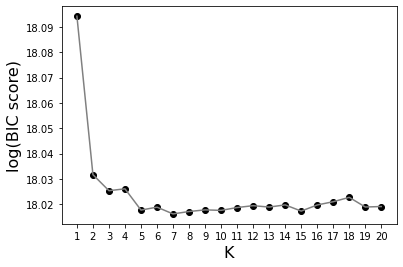

In [306]:
KK = ['1','2', '3', '4', '5','6','7','8','9','10',
     '11','12','13','14','15','16','17','18','19','20']
scores = [np.log(BIC.iloc[0,2]), np.log(BIC.iloc[1,2]), np.log(BIC.iloc[2,2]), 
          np.log(BIC.iloc[3,2]),np.log(BIC.iloc[4,2]), np.log(BIC.iloc[5,2]), 
          np.log(BIC.iloc[6,2]), np.log(BIC.iloc[7,2]),np.log(BIC.iloc[8,2]), 
          np.log(BIC.iloc[9,2]), np.log(BIC.iloc[10,2]), np.log(BIC.iloc[11,2]),
         np.log(BIC.iloc[12,2]), np.log(BIC.iloc[13,2]),np.log(BIC.iloc[14,2]),
         np.log(BIC.iloc[15,2]),np.log(BIC.iloc[16,2]),np.log(BIC.iloc[17,2]),
         np.log(BIC.iloc[18,2]),np.log(BIC.iloc[19,2])]
plt.plot(KK, scores, c='grey')
plt.scatter(KK, scores, c='black')

#plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('K', fontdict={'size': 16})
plt.ylabel('log(BIC score)', fontdict={'size': 16})
plt.show()